Epoch 1: Total=55.0706, Recon=54.8664, KL=255.2829
Epoch 2: Total=2.3871, Recon=1.9541, KL=541.3324
Epoch 3: Total=1.6079, Recon=1.1118, KL=620.0710
Epoch 4: Total=1.3400, Recon=0.8117, KL=660.4198
Epoch 5: Total=1.1911, Recon=0.6443, KL=683.4893
Epoch 6: Total=1.0983, Recon=0.5413, KL=696.2094
Epoch 7: Total=1.0289, Recon=0.4660, KL=703.6810
Epoch 8: Total=0.9766, Recon=0.4114, KL=706.5010
Epoch 9: Total=0.9379, Recon=0.3732, KL=705.8121
Epoch 10: Total=0.9079, Recon=0.3446, KL=704.1226
Epoch 11: Total=0.8748, Recon=0.3146, KL=700.2806
Epoch 12: Total=0.8511, Recon=0.2942, KL=696.0597
Epoch 13: Total=0.8304, Recon=0.2777, KL=690.8820
Epoch 14: Total=0.8085, Recon=0.2590, KL=686.8830
Epoch 15: Total=0.7947, Recon=0.2494, KL=681.6328
Epoch 16: Total=0.7760, Recon=0.2344, KL=677.0124
Epoch 17: Total=0.7617, Recon=0.2232, KL=673.1829
Epoch 18: Total=0.7483, Recon=0.2135, KL=668.4117
Epoch 19: Total=0.7409, Recon=0.2091, KL=664.7918
Epoch 20: Total=0.7247, Recon=0.1969, KL=659.7704


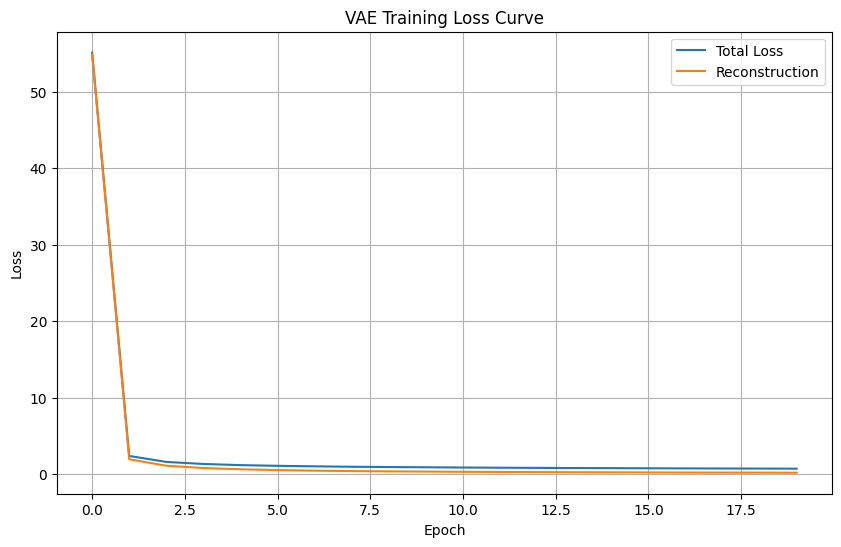

Top 10% 异常样本数量: 2300
        z_score  recon_error  age  duration  dupi  output_1  output_2  \
10     1.317270     0.001931   47      2717   542       100        39   
45     2.500622     0.002719   61      2719  1252        36        28   
54     2.933259     0.003008   71      2719  2601        30        34   
57     2.471009     0.002700   80      2906   821       100        44   
62     1.494505     0.002049   31      2588   645        51        30   
...         ...          ...  ...       ...   ...       ...       ...   
22953  2.502409     0.002720   26      2658  1554        43        31   
22976  1.624051     0.002135   24      3095  1053        39        19   
22989  1.170927     0.001833   70     -2941  1226        47        40   
22992  1.751483     0.002220   63      2913   117        50        30   
22996  1.337337     0.001944   87      2901  1651        66        26   

       output_3  output_4  output_5  output_6  
10           52       102         1         1  
45    

/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998

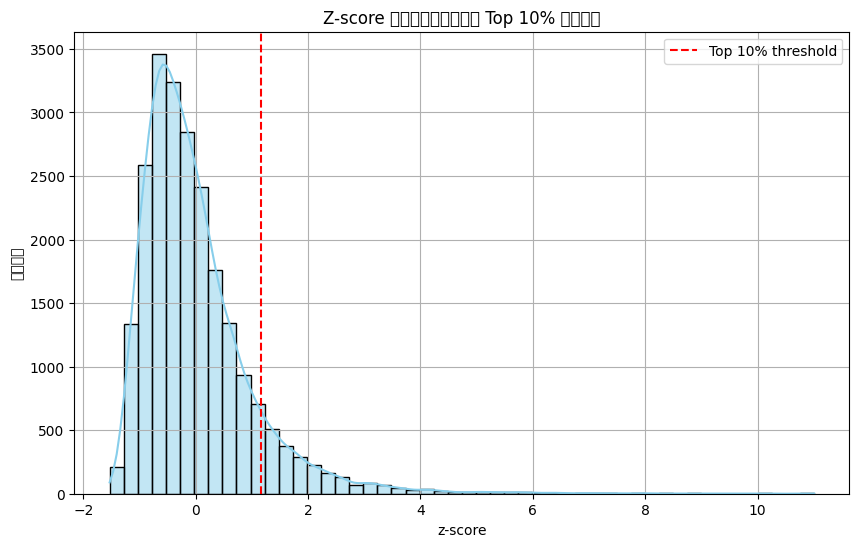

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# =================== #
#     Set Seed        #
# =================== #
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =================== #
#     Load Data       #
# =================== #
df = pd.read_csv("simulated_23_anomaly_dataset.csv")
feature_cols = ['age', 'duration', 'dupi',
                'output_1', 'output_2', 'output_3',
                'output_4', 'output_5', 'output_6']
X = df[feature_cols].values.astype(np.float32)

# Standardize all data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
data_loader = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

# =================== #
#     VAE Modules     #
# =================== #
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return self.fc2(h)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# =================== #
#     Training VAE    #
# =================== #
input_dim = X.shape[1]
latent_dim = 20
beta = 0.0008

vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def loss_fn(x, x_hat, mu, logvar, beta):
    recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

loss_list, recon_list, kl_list = [], [], []

vae.train()
for epoch in range(20):
    total_loss, total_recon, total_kl = 0, 0, 0
    for (x_batch,) in data_loader:
        x_hat, mu, logvar = vae(x_batch)
        loss, recon, kl = loss_fn(x_batch, x_hat, mu, logvar, beta=beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
    loss_list.append(total_loss)
    recon_list.append(total_recon)
    kl_list.append(total_kl)
    print(f"Epoch {epoch+1}: Total={total_loss:.4f}, Recon={total_recon:.4f}, KL={total_kl:.4f}")

# =================== #
#     Plot Loss       #
# =================== #
plt.figure(figsize=(10,6))
plt.plot(loss_list, label='Total Loss')
plt.plot(recon_list, label='Reconstruction')
# plt.plot(kl_list, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# =================== #
#    Anomaly Score    #
# =================== #
vae.eval()
recon_errors = []
mu_all = []

with torch.no_grad():
    for (x_batch,) in data_loader:
        x_hat, mu, logvar = vae(x_batch)
        mse_batch = nn.functional.mse_loss(x_hat, x_batch, reduction='none')
        batch_errors = mse_batch.mean(dim=1)
        recon_errors.extend(batch_errors.numpy())
        mu_all.append(mu.numpy())

recon_errors = np.array(recon_errors)
mu_all = np.vstack(mu_all)

# Compute z-score
mean_err = recon_errors.mean()
std_err = recon_errors.std()
z_scores = (recon_errors - mean_err) / std_err

# Save to DataFrame
df["recon_error"] = recon_errors
df["z_score"] = z_scores

# =================== #
#   Top 10% Anomaly   #
# =================== #
threshold = np.percentile(z_scores, 90)
df["is_anomaly"] = df["z_score"] >= threshold

top10pct_df = df[df["is_anomaly"]]
print(f"Top 10% 异常样本数量: {len(top10pct_df)}")
print(top10pct_df[["z_score", "recon_error"] + feature_cols])

# =================== #
#     Plot z-score    #
# =================== #
plt.figure(figsize=(10,6))
sns.histplot(df["z_score"], bins=50, kde=True, color="skyblue")
plt.axvline(threshold, color='red', linestyle='--', label='Top 10% threshold')
plt.title("Z-score 分布（重建误差）及 Top 10% 异常样本")
plt.xlabel("z-score")
plt.ylabel("样本数量")
plt.legend()
plt.grid(True)
plt.show()

Shapiro-Wilk 正态性检验（前10个 latent 维度）
dim  0 | mean=+0.44, std=0.95 | Shapiro p=1.11e-32
dim  1 | mean=+0.78, std=0.95 | Shapiro p=1.14e-30
dim  2 | mean=-0.15, std=1.05 | Shapiro p=3.62e-18
dim  3 | mean=+0.29, std=1.10 | Shapiro p=1.92e-21
dim  4 | mean=+0.23, std=1.24 | Shapiro p=2.63e-08
dim  5 | mean=-0.74, std=1.02 | Shapiro p=1.31e-27
dim  6 | mean=-0.03, std=1.06 | Shapiro p=2.41e-13
dim  7 | mean=-0.74, std=0.92 | Shapiro p=3.57e-23
dim  8 | mean=-0.17, std=0.90 | Shapiro p=6.27e-31
dim  9 | mean=+0.24, std=1.13 | Shapiro p=2.81e-22


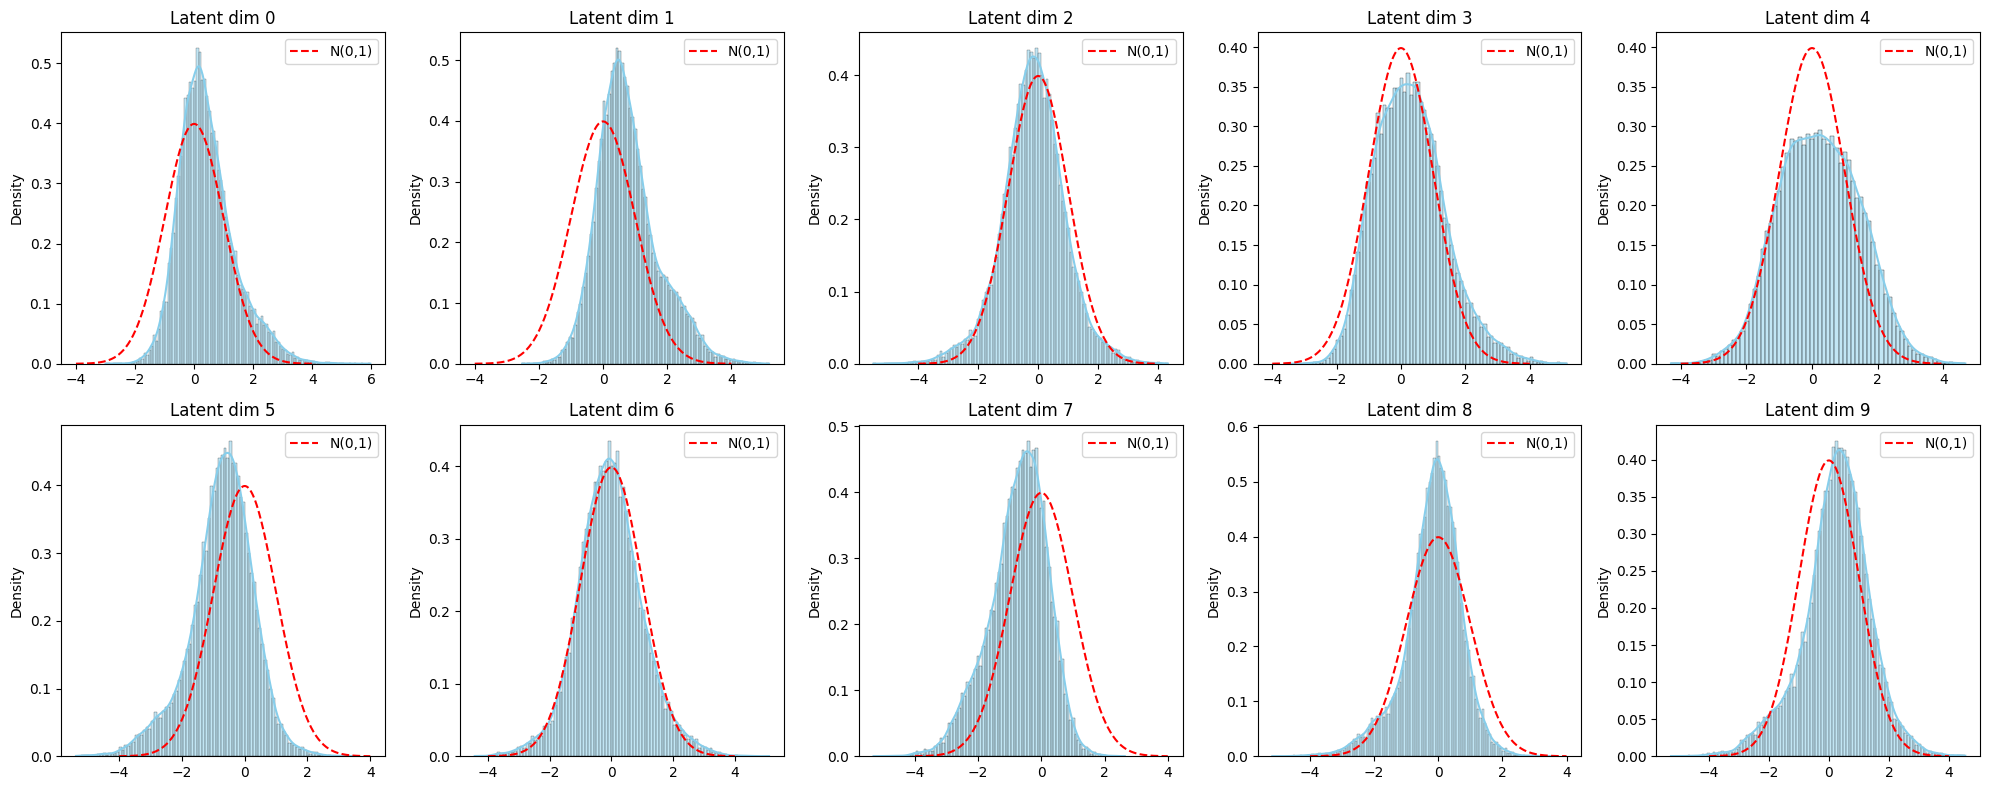

In [2]:
# =================== #
# Shapiro-Wilk 正态性检验 (前10个 latent dim)
# =================== #
from scipy.stats import shapiro

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
print("Shapiro-Wilk 正态性检验（前10个 latent 维度）")
for i in range(10):
    ax = axes[i//5][i%5]
    z = mu_all[:, i]
    sns.histplot(z, kde=True, stat="density", ax=ax, color="skyblue")
    x_vals = np.linspace(-4, 4, 200)
    ax.plot(x_vals, 1/np.sqrt(2*np.pi)*np.exp(-x_vals**2/2), 'r--', label="N(0,1)")
    ax.set_title(f"Latent dim {i}")
    ax.legend()
    stat, pval = shapiro(z[:5000])  # 取前 5000 个样本做检验
    print(f"dim {i:2d} | mean={np.mean(z):+.2f}, std={np.std(z):.2f} | Shapiro p={pval:.3g}")
plt.tight_layout()
plt.show()




/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/1509425138.py:27: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/1509425138.py:27: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/1509425138.py:27: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/1509425138.py:27: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/1509425138.py:27: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7

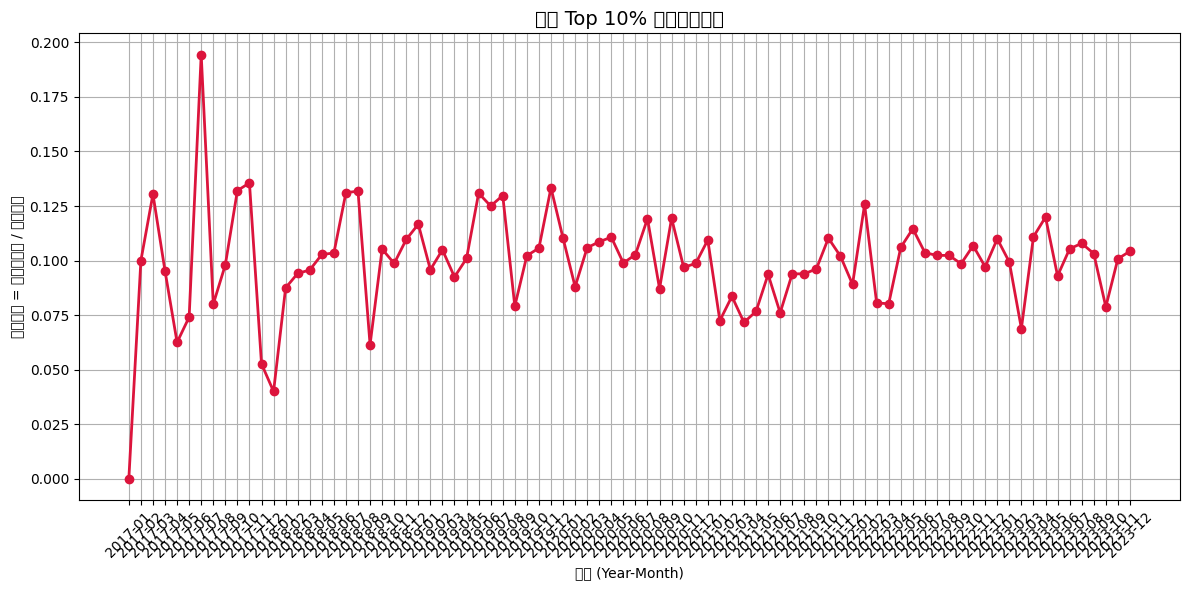


每月异常密度统计：
              Total Samples  Top 10% Anomalies  Anomaly Density
initial_date                                                   
2017-01                   4                  0            0.000
2017-02                  10                  1            0.100
2017-03                  23                  3            0.130
2017-04                  21                  2            0.095
2017-05                  32                  2            0.062
...                     ...                ...              ...
2023-08                 519                 56            0.108
2023-09                 533                 55            0.103
2023-10                 533                 42            0.079
2023-11                 506                 51            0.101
2023-12                 537                 56            0.104

[84 rows x 3 columns]


In [3]:
# =================== #
# 按 initial_date 分析每月异常密度
# =================== #
df["initial_date"] = pd.to_datetime(df["initial_date"])

# 所有样本按月统计
all_months = df["initial_date"].dt.to_period("M")
all_month_counts = all_months.value_counts().sort_index()

# 异常样本按月统计
anomaly_months = df[df["is_anomaly"]]["initial_date"].dt.to_period("M")
anomaly_counts = anomaly_months.value_counts().sort_index()

# 对齐索引
anomaly_counts = anomaly_counts.reindex(all_month_counts.index, fill_value=0)
anomaly_density = anomaly_counts / all_month_counts

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(anomaly_density.index.astype(str), anomaly_density.values,
         marker='o', color='crimson', linewidth=2)
plt.title("每月 Top 10% 异常样本密度", fontsize=14)
plt.xlabel("月份 (Year-Month)")
plt.ylabel("异常密度 = 异常样本数 / 总样本数")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# （可选）输出表格
density_df = pd.DataFrame({
    "Total Samples": all_month_counts,
    "Top 10% Anomalies": anomaly_counts,
    "Anomaly Density": anomaly_density
})
print("\n每月异常密度统计：")
print(density_df.round(3))

In [4]:
# =================== #
# 保存完整结果
# =================== #
df.to_csv("vae_anomaly_results.csv", index=False)
top10pct_df.to_csv("vae_top10percent_anomalies.csv", index=False)
density_df.to_csv("vae_anomaly_density_by_month.csv")
print("\n✅ 结果已保存为：")
print(" - vae_anomaly_results.csv")
print(" - vae_top10percent_anomalies.csv")
print(" - vae_anomaly_density_by_month.csv")


✅ 结果已保存为：
 - vae_anomaly_results.csv
 - vae_top10percent_anomalies.csv
 - vae_anomaly_density_by_month.csv


/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3715833890.py:11: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3715833890.py:11: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3715833890.py:11: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3715833890.py:11: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3715833890.py:11: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7

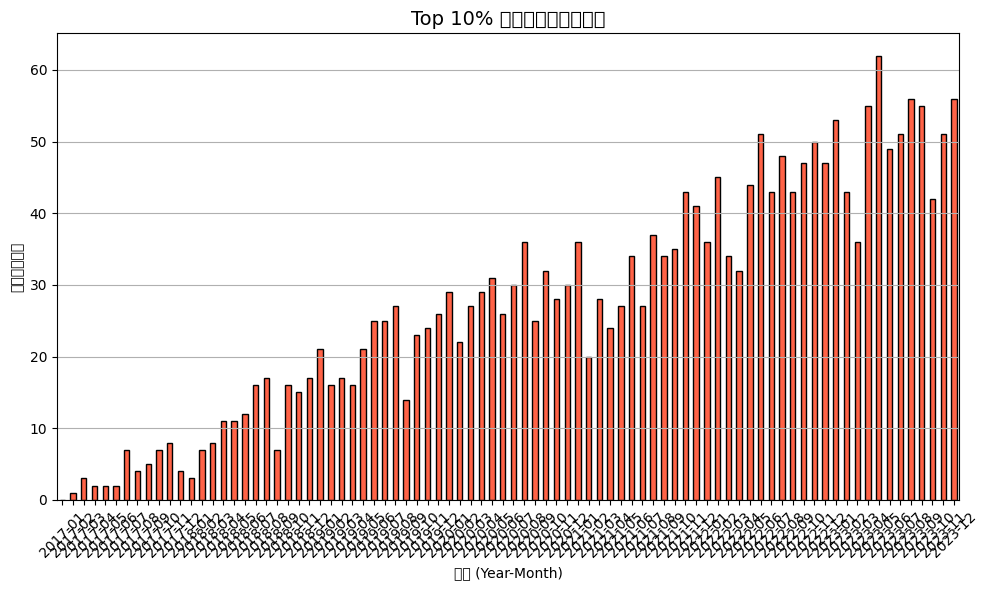

In [5]:
# =================== #
# Top 10% 异常样本的月份分布（数量）
# =================== #
plt.figure(figsize=(10, 6))
anomaly_counts.plot(kind='bar', color="tomato", edgecolor="black")
plt.title("Top 10% 异常样本的月份分布", fontsize=14)
plt.xlabel("月份 (Year-Month)")
plt.ylabel("异常样本数量")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [6]:
# 按季度提取（例如 2023Q1, 2023Q2...）
df["initial_date"] = pd.to_datetime(df["initial_date"])
df["quarter"] = df["initial_date"].dt.to_period("Q")

# 所有样本每季度计数
all_quarter_counts = df["quarter"].value_counts().sort_index()

# 异常样本每季度计数
anomaly_quarters = df[df["is_anomaly"]]["quarter"]
anomaly_quarter_counts = anomaly_quarters.value_counts().sort_index()

# 对齐索引并计算密度
anomaly_quarter_counts = anomaly_quarter_counts.reindex(all_quarter_counts.index, fill_value=0)
anomaly_quarter_density = anomaly_quarter_counts / all_quarter_counts

/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/4009144656.py:8: UserWarning: Glyph 23395 (\N{CJK UNIFIED IDEOGRAPH-5B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/4009144656.py:8: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/4009144656.py:8: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/4009144656.py:8: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/4009144656.py:8: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52

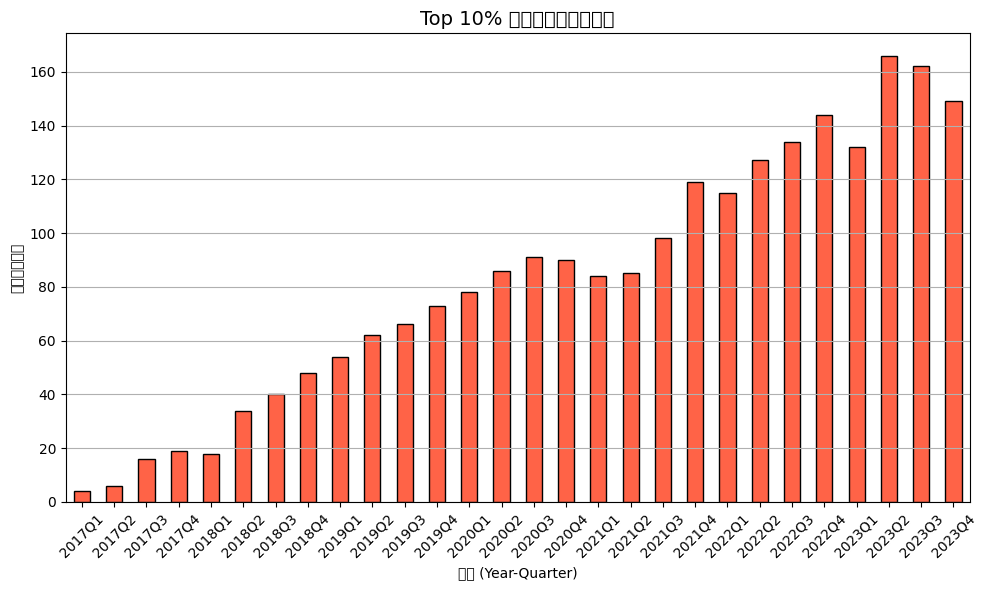

In [7]:
plt.figure(figsize=(10, 6))
anomaly_quarter_counts.plot(kind='bar', color="tomato", edgecolor="black")
plt.title("Top 10% 异常样本的季度分布", fontsize=14)
plt.xlabel("季度 (Year-Quarter)")
plt.ylabel("异常样本数量")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3952816059.py:10: UserWarning: Glyph 23395 (\N{CJK UNIFIED IDEOGRAPH-5B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3952816059.py:10: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3952816059.py:10: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3952816059.py:10: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_31170/3952816059.py:10: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7

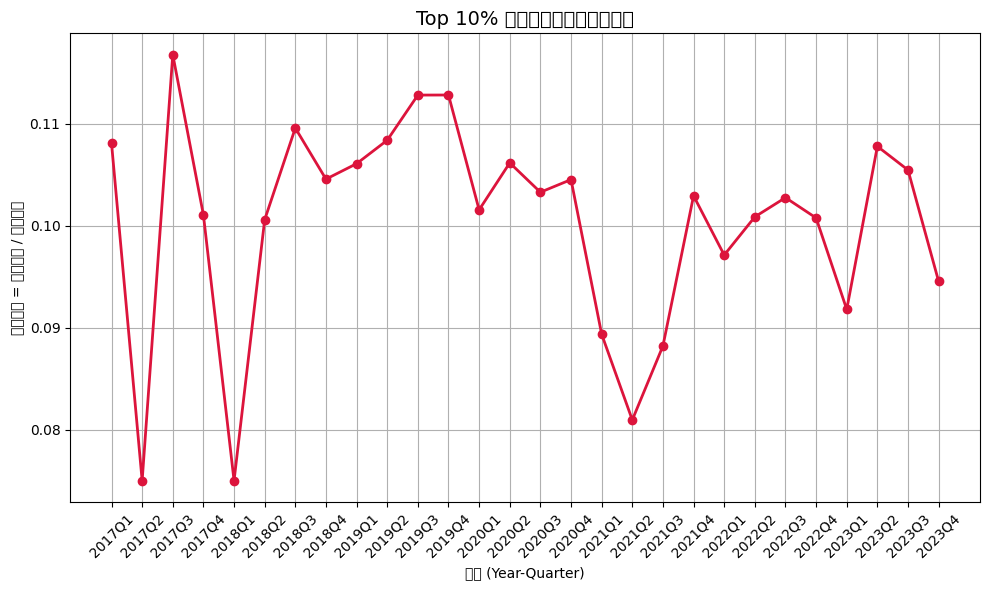

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(anomaly_quarter_density.index.astype(str),
         anomaly_quarter_density.values,
         marker='o', color='crimson', linewidth=2)
plt.title("Top 10% 异常样本密度（按季度）", fontsize=14)
plt.xlabel("季度 (Year-Quarter)")
plt.ylabel("异常密度 = 异常样本 / 总样本数")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
quarter_df = pd.DataFrame({
    "Total Samples": all_quarter_counts,
    "Top 10% Anomalies": anomaly_quarter_counts,
    "Anomaly Density": anomaly_quarter_density
})
quarter_df.to_csv("vae_anomaly_density_by_quarter.csv")
print("\n✅ 季度分析结果已保存为：vae_anomaly_density_by_quarter.csv")


✅ 季度分析结果已保存为：vae_anomaly_density_by_quarter.csv
